# <center>Image Recognition Using Convolutional Neural Networks: Cats Cows vs vs Dogs  </center>

We train a fully connected neural network to classify cats-vs-cows-vs-dogs on a training dataset consisting of 150 images of cats 150 images of cows and 150 images of dogs.
With careful optimization and tuning, observed that accuracy on the training data is higher than the  accuracy on the validation data. This showed that our fully connected network terribly overfit the training data and was not able to generalize to the validation data. Adding regularization with drop out, weight decay, and early stopping narrowd the gap between training and validation error but caused serious underfitting and did not improve the validation accuracy. There are two reasons why our fully connected network failed to generalize well to the test data:

1. The fully connected network ( in particular the first hidden layer) had over 1 million parameters which is several orders of magnitude larger than the available training data (only 2k) used to train those parameters.
2. The fully connected network looks at each input pixel individually and is not able to extract local spatial features (such as edges,skin texture, cat or dog ears, eyes, etc.) from the image.
As we learned in the lectures  this week, convolutional neural networks are optimized for learning spatial features from images through their local connectivity. They also share parameters between neurons in each layer, dramatically reducing the number of parameters and enabling neruons in each layer to detect same features in different parts of the image.

 Tried to solve cat vs cow vs dogs classification problem  using  a CNN instead of fully connected network.

1. We train a baseline CNN from scratch to classify cats vs dogs. This gives us a validation accurracy of about 77-78% ( a big improvement over the fully connected network)
2. At this point, the issue would be mainly overfitting, We use several techniques including data augmentation, regularization, replacing standard convolution with dept-hwise separable convolution and adding residual connections to migitgate overfitting. That will get us to validation accurracy of about 90%.
3. Finally, we use transfer learning and get a validation accurracy of about 97%

Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pre- trained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.




In [ ]:
import zipfile, os
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow.keras.utils








## 1. Getting and Preparing Data ( Copied from previous lab)


Downloaded the data and copied it to the directory structure that can be read by <code>image_dataset_from_directory</code>.




In [ ]:
#Getting the Data
# downloading the files from dropbox
#!wget --no-check-certificate  "https://uofi.box.com/shared/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip" -O cats-vs-dogs.zip

#extrac the zip file downloaded
zip_ref = zipfile.ZipFile('/content/cows-vs-cats-vs-dogs.zip', 'r')
zip_ref.extractall()

In [ ]:
!pip install rarfile


In [ ]:
#Referred google
#!apt-get update
#!apt-get install unrar

import rarfile
import os

# Assuming the file is a RAR archive
rar_file_path = '/content/trees-vs-cats-vs-dogs.rar'

# Create a RarFile object
rar = rarfile.RarFile(rar_file_path)

# Extract all files to the current directory
rar.extractall()

# Optionally, delete the original RAR file
#os.remove(rar_file_path)

In [ ]:


#specify the directory where we store smaller data
base_dir = '/content/cows-vs-cats-vs-dogs_small'
#delete the directory if already exist
if(os.path.exists(base_dir)):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

#create subdirectories for train/test/validation  under the base directory
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

#create subdirectories for cat and dog under train directory
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)
train_cows_dir = os.path.join(train_dir, 'cows')
os.mkdir(train_cows_dir)

#create subdirectories for cat and dog under validation directory
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)
validation_cows_dir = os.path.join(validation_dir, 'cows')
os.mkdir(validation_cows_dir)

#create subdirectories for cat and dog under test directory
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)
test_cows_dir = os.path.join(test_dir, 'cows')
os.mkdir(test_cows_dir)



In [ ]:
original_dataset_dir="/content/cows-vs-cats-vs-dogs"
#original_dataset_dir = os.path.join('trees-vs-cats-vs-dogs', 'trees-vs-cats-vs-dogs')
#Total images- 151 , train-105,val-23(105-128),test-23(128-151)

#copying the first 1000 cat images to the train/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(105)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 cats images to the validation/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(105, 128)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 cats images to the test/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(128, 151)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the first 1000 dog images to the train/dogs directory
fnames = ['dog.{}.jpg'.format(i) for i in range(105)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 dog images to the validation/dogs directory
fnames = ['dog.{}.jpg'.format(i) for i in range(105, 128)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 cats images to the test/cats directory
fnames = ['dog.{}.jpg'.format(i) for i in range(128, 151)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

#copying the first 1000 dog images to the train/dogs directory
fnames = ['cow.{}.jpg'.format(i) for i in range(105)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cows_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 dog images to the validation/dogs directory
fnames = ['cow.{}.jpg'.format(i) for i in range(105, 128)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cows_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 dog images to the test/dogs directory
fnames = ['cow.{}.jpg'.format(i) for i in range(128, 151)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cows_dir, fname)
  shutil.copyfile(src, dst)




In [ ]:
#Check to see if the data is copied correctly to the directory structure
print('total training cats images:', len(os.listdir(train_cats_dir)))
print('total training dogs images:', len(os.listdir(train_dogs_dir)))
print('total training cows images:', len(os.listdir(train_cows_dir)))
print('total validation cats images:', len(os.listdir(validation_cats_dir)))
print('total validation dogs images:', len(os.listdir(validation_dogs_dir)))
print('total validation cows images:', len(os.listdir(validation_cows_dir)))
print('total test cats images:', len(os.listdir(test_cats_dir)))
print('total test dogs images:', len(os.listdir(test_dogs_dir)))
print('total test cows images:', len(os.listdir(test_cows_dir)))

total training cats images: 105
total training dogs images: 105
total training cows images: 105
total validation cats images: 23
total validation dogs images: 23
total validation cows images: 23
total test cats images: 23
total test dogs images: 23
total test cows images: 23


 The utility function<code>image_dataset_from_directory</code> creates <code>tf.data.Dataset</code> object configured to read the image files, shuffle them, decode them to tensors, resize them to a shared size,and pack them into batches.

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
train_dir,
image_size=(180, 180),
batch_size=32)


validation_dataset = image_dataset_from_directory(
validation_dir,
image_size=(180, 180),
batch_size=32)


test_dataset = image_dataset_from_directory(
test_dir,
image_size=(180, 180),
batch_size=32,
shuffle=False)

Found 315 files belonging to 3 classes.
Found 69 files belonging to 3 classes.
Found 69 files belonging to 3 classes.


first image array tf.Tensor(
[[[149.66373  112.66373  106.66373 ]
  [147.31749  104.342476 101.00081 ]
  [153.19576  103.596565  97.866005]
  ...
  [ 53.94379   53.94379   53.94379 ]
  [ 59.68335   59.68335   59.68335 ]
  [ 58.229576  58.229576  58.229576]]

 [[183.84494  146.2366   136.20311 ]
  [178.90106  137.60938  129.7682  ]
  [169.46667  121.60556  114.48218 ]
  ...
  [ 56.870247  56.870247  56.870247]
  [ 56.52549   56.52549   56.52549 ]
  [ 60.33056   60.33056   60.33056 ]]

 [[196.54839  156.85394  138.81227 ]
  [207.31886  164.97165  150.2772  ]
  [215.87828  169.22551  158.18384 ]
  ...
  [ 59.05881   59.05881   59.05881 ]
  [ 54.311104  54.311104  54.311104]
  [ 57.493793  57.493793  57.493793]]

 ...

 [[253.       253.       253.      ]
  [253.       253.       253.      ]
  [253.       253.       253.      ]
  ...
  [ 33.929775  30.929775  25.929775]
  [ 35.302437  32.302437  27.302439]
  [ 38.56961   34.264008  29.91681 ]]

 [[253.       253.       253.      ]
  [253. 

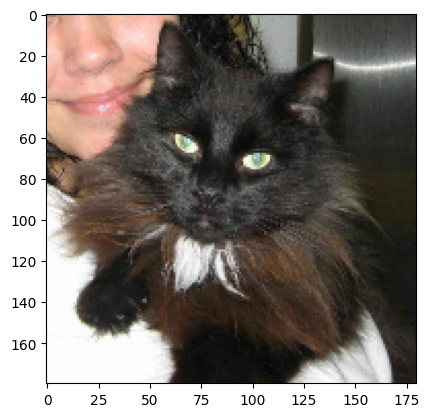

In [ ]:
for train_x_batch, train_y_batch in train_dataset:
    print('first image array', train_x_batch[0])
    plt.imshow(train_x_batch[0].numpy().astype("uint8"))
    print('first label', train_y_batch[0])
    break

# 2. Creating a Baseline Convolutional Neural Network from Scratch


Started with a simple model consisting of four convolutional layers, each followed by a batchnormalization layer and a maxpooling layer.

Started the model with an input layer which holds information about the shape and type of the data that the model will process and a rescaling layer which scales image pixels to [0, 1] range by dividing them by 255. Noted that unlike the <code>Dense </code> layer, the image does not need to be flattened for <code>conv2D</code> layer.

Then we use repeated blocks with increasing channel/filter size. Each block consists of a convolutional + relu + batchnormalization layers followed by a maxpooling layer.

Similar to VGG blocks all convolution layers use $3\times 3$ kernel size with padding one preserving the height and width of their input feature maps. For instance:
<code>layers.Conv2D(filters=filter, kernel_size=3, padding="same", use_biase=False)</code>.

<code>conv2D</code> means that this layer performs a convolution operation with a two dimensional kernel. <code>"filter"</code> is the number of channels used in the convolution layer, that is the number of channels in the output of the convolutional layer <code>kernel_size=3</code> is the size of each filter/kernel. <code>padding="same</code>means that we want to pad the input such that the output of the convolution layer has the same resolution as its input. We set <code>use_bias=False</code> because as we mentioned in the optimization lecture (slide 60) since batchnormalization centers the data around mean, the bias term in affine transformation gets cancelled out so there is no need to use bias in the layer that uses batch normalzation.


we start with 32 channels for the first two convolution layers and double the number of channels after each max pooling layer until we get to 512.  In almost all CNN architectures you see that the number of channels progressively increases  while the height and width of the feature maps decrease with max pooling. It is also common to use Batchnormalization in each convolution layer to speed up learning and improve generalization.

 All max pooling layers use $2\times 2$ filters with stride 2 (<code>pool_size=2</code>), down sampling (halving) the height and width of their input feature maps.

Most modern CNN architectures use a global average pooling operation (GAP) at the end to partially or fully replace the stack of fully connected layers that have been traditionally used in CNN. There are two ways to incoporate GAP into a CNN:
* abondon using any fully connected layers altogether and supply the output of the GAP directly to a softmax function. This requires that the linput to GAP has as many channels  as the number of target classes. The GAP then takes the average of the feature map in each channel and send it to a softmax (or sigmoid) function for a multiclass ( or binary) classification problem.

* In the other form, one or more fully connected layers can be used along with the global average pooling layer. In this case, the input to GAP doesn't necessarily have to have the same number of channels as the target classes.For instance, in GoogleNet and Resnet the output of GAP is supplied to a dense layer with softmax activation.

Here we supply the output of GAP directly to a dense output layer. As this is a binary classificaiton problem, the output layer must have one neuron with sigmoid activation to output the probability of one class vs the other.

In keras, you can use GAP by simply adding  <code>        layers.GlobalAveragePooling2D()</code> to your network. This layes does not have any trainable parameter.

Created a function build_baseline that configures the network architecture explained above  and return the model.


In [ ]:
def build_baseline(input_shape, filters):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.Rescaling(1./255)(input)


  for filter in filters:
    #A block of two conv+batchnorm+relu  layers for extractign features
    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)


    #max pooling for downsampling
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)


  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(3, activation="softmax")(x)
  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model
baseline=build_baseline(input_shape=(180,180,3), filters=[32,64,128,256, 512])
print(baseline.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 45, 45, 128)         │              

 Total params: 4,721,699 (18.01 MB)

 Trainable params: 4,717,731 (18.00 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


Trained this model on the training data and use validation set to evaluate it. Note that we use three callbacks:
* **Early stopping:** to stop the training if validation loss does not improve by at least 0.0001 in 10 epochs

* **ModelCheckpoint** which is typically used with early stopping and lets you continually save the model during training after each epoch. We configure it with the path where to save the file, as well as the arguments <code>save_best_only=True</code> and <code>monitor="val_loss"</code>: they tell the callback to only save a new file
(overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file. Later, if we want to load a model from a checkpoint, we can just do <code>keras.models.load_model (filepath)</code>

Note:

The filepath could be a path in  google drive. The following code mounts  google drive in the current colab session. When you run it, a window pops up that asks you to authorize colab access your drive. once  authorized,  google drive will be accessible under "/content/drive/MyDrive"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that we can access google drive, we can save the checkpointed model in drive/MyDrive/cnn_lab/baseline_checkpoint. This means that the best model during training will be saved in cnn_lab/baseline_checkpoint in your google drive and you can load and use this model later.

Checking the format of albels in dataset:

In [ ]:
#Referred google
# Get a batch of data from the training dataset
for images, labels in train_dataset.take(1):
    print("Labels in the batch:", labels.numpy())
    break


Labels in the batch: [1 2 2 0 0 1 1 2 2 0 0 0 2 0 2 1 2 2 1 1 0 1 0 2 2 2 1 1 0 1 2 1]


From the above,it is  known that labels are integer encoded,hence saparse categorical cross_entropy is the right loss function

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baseline.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

#callback for early stopping. stop the training if the validation_loss does not improve after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True)

#save the checkpointed model in your google drive cnn_lab directory: "drive/MyDrive/cnn_lab/baseline_checkpoint" .
checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/cnn_lab/baseline_checkpoint.keras",save_best_only=True, monitor="val_loss")

history = baseline.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 1000,
            verbose = 1,
            callbacks=[early_stopping, checkpoint])


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6489 - loss: 0.7849 - val_accuracy: 0.3333 - val_loss: 4.0199
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.6746 - loss: 0.7003 - val_accuracy: 0.3333 - val_loss: 2.4996
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6325 - loss: 0.7475 - val_accuracy: 0.3333 - val_loss: 4.4521
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6530 - loss: 0.7292 - val_accuracy: 0.3333 - val_loss: 6.3420
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7413 - loss: 0.5943 - val_accuracy: 0.3333 - val_loss: 11.9707
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7723 - loss: 0.5683 - val_accuracy: 0.3333 - val_loss: 15.0202
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.7513 - loss: 0.5348 - val_accuracy: 0.3333 - val_loss: 13.7750
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7916 - loss: 0.4920 -

Using the above  small CNN, we were able to get the
validation accurracy up to 33.33%  with both 50 and 150epochs of training.

Loss values increased with 300 epochs, 150 epochs compared to 50 epochs but the accuracies are almost the same with both trainings.

**With 50,150,300 epochs:**

 Training accuracy is around 77 % and validtaion accuracy is around 33 % and a huge gap between them says that  overfitting is occurring despite the increase in number of epochs while training.

With 500 epochs:

Training accuracy is around 80 % and validtaion accuracy- 33%
Training loss:0.4, Validation loss: 0.4

**With 1000 epochs:**

Improvement is not seen with increase in numberof epochs of training.

Training accuracy is around 73 % and validtaion accuracy- 33%
Training loss:0.5, Validation loss: 4.4

The learning curves for training and validation are as below:



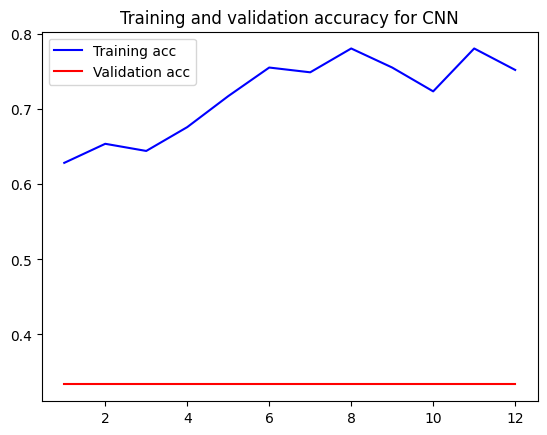

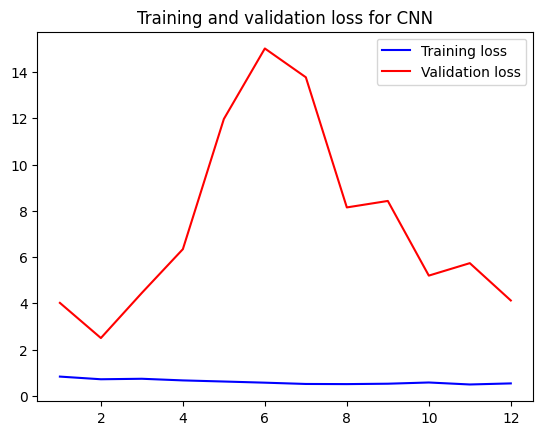

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

## i. What can you understand from the learning curves? Does your model overfit?

These plots are characteristic of **overfitting** as training accuracy is higher tahn validation accuracy and huge gapbetweentheir losses too. The training accuracy increases linearly over time with spikes ranging between 77%-80%  whereas the validation accuracy peaks at 33% which is very low value. The validation loss showed spikes  whereas the training loss keeps decreasing linearly and gradually with little improvement.



##ii.
adding more convolutional layers, increased the depth
(number of channels as you add layers. )

In [ ]:
def build_baseline(input_shape, filters):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.Rescaling(1./255)(input)


  for filter in filters:
    #A block of two conv+batchnorm+relu  layers for extractign features
    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)


    #max pooling for downsampling
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)


  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(3, activation="softmax")(x)
  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model
baseline=build_baseline(input_shape=(180,180,3), filters=[32,64,128,256, 512])
print(baseline.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_20 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_21 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_22 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_23 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_24 (ReLU)                      │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 90, 90, 64)          │          36,9

 Total params: 11,016,931 (42.03 MB)

 Trainable params: 11,008,995 (42.00 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baseline.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

#callback for early stopping. stop the training if the validation_loss does not improve after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True)

#save the checkpointed model in your google drive cnn_lab directory: "drive/MyDrive/cnn_lab/baseline_checkpoint" .
checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/cnn_lab/baseline_checkpoint.keras",save_best_only=True, monitor="val_loss")

history = baseline.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 200,
            verbose = 1,
            callbacks=[early_stopping, checkpoint])


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3817 - loss: 1.0963 - val_accuracy: 0.3333 - val_loss: 13.7587
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.4282 - loss: 1.0767 - val_accuracy: 0.3333 - val_loss: 22.0851
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.5746 - loss: 0.8692 - val_accuracy: 0.3333 - val_loss: 296.2464
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.5498 - loss: 0.9302 - val_accuracy: 0.3333 - val_loss: 86.7104
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.6123 - loss: 0.7563 - val_accuracy: 0.3333 - val_loss: 78.2958
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.5834 - loss: 0.7811 - val_accuracy: 0.3478 - val_loss: 24.2113
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.5326 - loss: 0.7986 - val_accuracy: 0.3623 - val_loss: 15.3562
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - accuracy: 0.5771 - loss: 0.7138 - v

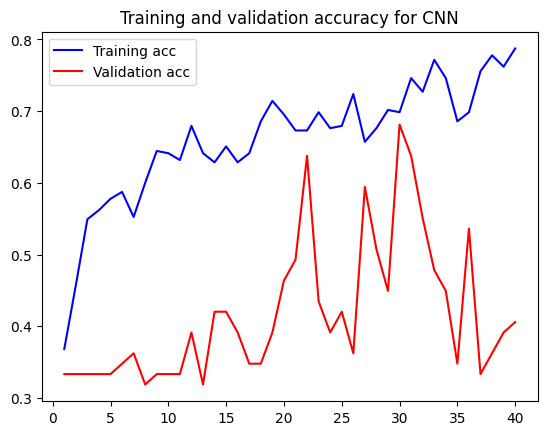

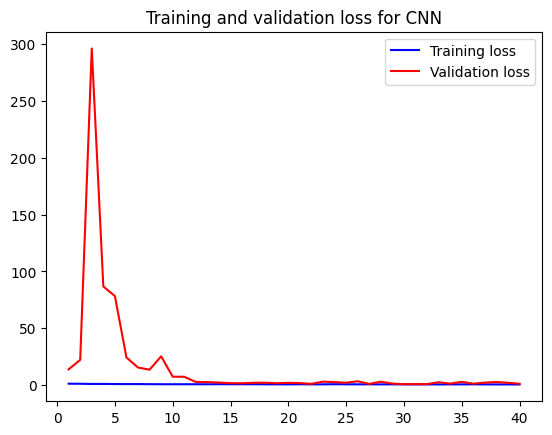

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

##ii. If your model does not overfit,
 try increasing the capacity of your model by adding more convolutional layers, make sure that you increase the depth
(number of channels as you add layers. Draw the learning curves again. How
did adding more convolutional layers affected your training and validation
accuracies? Does the new model overfit?

At 100 epochs:

*Adding more convolutionalblocks to a base line model and training it resulted in decrease of training accuracy from 77% to 60 % whereas the avlidation accuracy showed a little increase from33% to 34%. But the huge gap between losses and the highe training accuracy over the validation one shows the sign of overfitting and no improvement in generalization.*

With 200 epochs:

*accuracy: 0.7795 - loss: 0.4820 - val_accuracy: 0.4058 - val_loss: 1.0722*

**Overfitting occurs as the training accuracy is significantly higher than validation accuracy which is around 40% & validation loss is slightly higher tahn training loss even though converged.**

# 3. Improving the Baseline model







Used a few training samples (151) compared to the number of parmeters, overfitting is the major concern. Applying  techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization).

Dropout is typically not used with convolutional layers because, due to parameter sharing, these layer are less prone to overfitting. Dropout is typically more effective if it is used between fully connected/Dense layers. In the network we designed here, there is no dense layer except the output layer.

**Note**: we should never apply drop out to the output layer. However, the dropout can be applied right after the GlobalAveragePooling layer.

Applying three methods to improve generalization of our baseline model:
* Data Augmentation
* residual connections
* depth-wise separable convolutional layers



#  Using Data Augmentation
The first thing recommended to improve generalization  in Goodfellow's deep learning book was to get more data. Overfitting is caused by having too few samples to learn from making it difficult (if not impossible) to train a model that can generalize to new data. Given infinite data,  model would be exposed to every possible aspect of the data distribution and you would never overfit. In real world; however, we always have limited training data and hence, our models are likely to overfit.

In many real world problems we may not have access to more data, data augmentation is a very effective method to improve generalization in particular, in image recognition problems. Data augmentation is used almost universally when processing images with deep-learning models.

In Keras, data augmentation can be done by adding a number of data augmentation layers available at at the start of  model. There are just a few layers available (such as <code>randomCrop</code>,<code>randomContrast</code>, <code>randomRotation</code>, <code>randmFlip</code>, <code>randomZoom</code>, etc.

Reference:

Tensorflow documentation for  [layers.experimental.preprocessing](layers.experimental.preprocessing).  

A sequential model that chains several random image transformations.

* <code>randomFlip("horizontal")</code> will apply horizontal flipping to a random 50% of the images that go through it.
* <code>RandomRotation(0.1)</code>:will rotate the input images by a random value in the range
[-10%, +10%] (these are fractions of a full circle—in degrees the range would be [-36degrees, +36 degrees]).

* <code>RandomZoom(0.2)</code>will zoom in or out of the image by a random factor in the range [-20%, +20%].



In [ ]:
def data_augmentation(x):
  x= layers.RandomFlip("horizontal")(x)
  x=layers.RandomRotation(0.1)(x)
  x=layers.RandomZoom(0.2)(x)
  return x


Note: data_augmentation does not have any learnable parameters.
Applied data_augmentation function to a sample image from the training data.
The following code segment gets the first image in a batch of images from train_dataset and augment it 9 times, displaying the augmented images. For each of the nine iterations, this is a different augmentation of the same image.

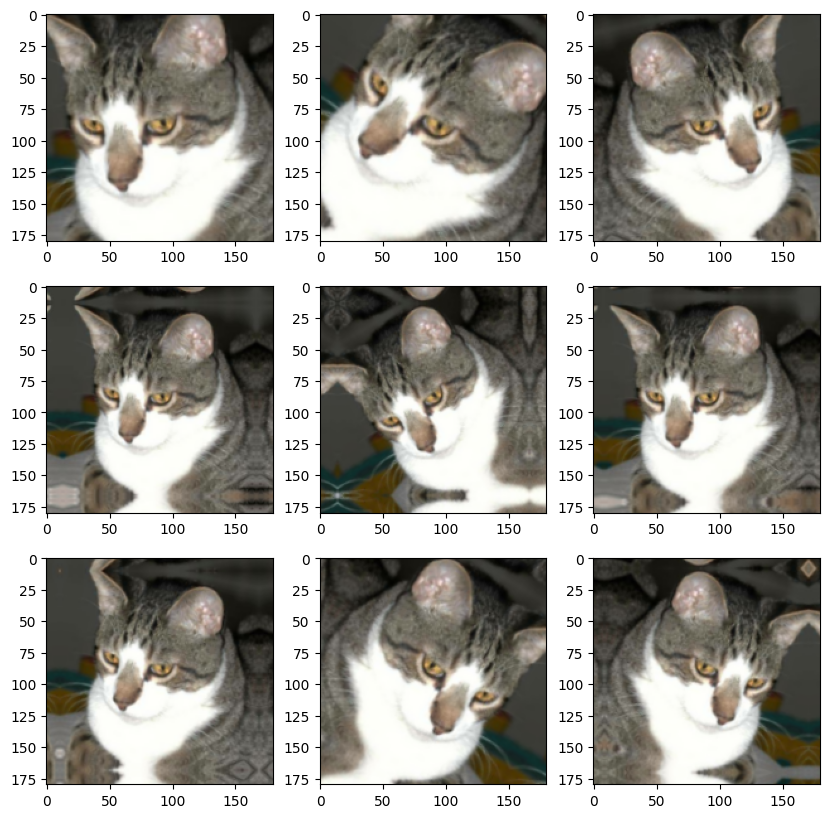

In [ ]:
plt.figure(figsize=(10, 10))

#Get a batch of train_dataset
for image_batch, _ in train_dataset:
    #get the first image in the batch
    sample_image= image_batch[0]
    break;

# apply data augmentation 9 times to the sample image and show the augmented images
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(sample_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))




If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—we can’t produce new information, we can only remix existing information. As such, this may not be enough to completely get rid of overfitting.

One last thing to know about random image augmentation layers, just like Dropout, they’re inactive during inference (when we call predict() or evaluate()). During evaluation,  model will behave just the same as when it did not include data augmentation and dropout.  

Adding the data_augmentation layers to our baseline model right before the rescaling layer. We also add a dropout after the final GlobalAveragePooling layer in an attempt to further reduce overfitting.

##v. Added a couple of dense layers + dropout after the GAP (Global Average
Pooling )layer and before the output layer. How did adding these layers
affected your model performance in terms of training and validation losses.
##v. Used data augmentation and retrained the model again from scratch. Does data
augmentation improve the validation performance of your baseline model?

In [ ]:
def build_baseline_with_aug(input_shape, filters):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #Add the data_augmentation layers here:
  x=data_augmentation(input)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.Rescaling(1./255)(x)


  for filter in filters:
    #conv batchnorm+relu for extracting features
    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    #max pooling for downsampling
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)

  x= layers.Dropout(0.2)(x)

  #The final output layer has 3 neurons with softmax activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(3, activation="softmax")(x)
  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model
baseline_with_aug=build_baseline_with_aug(input_shape=(180,180,3), filters=[32,64,128,256,512])
print(baseline_with_aug.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_19 (RandomFlip)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_19 (RandomRotation)  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_19 (RandomZoom)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_40 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_41 (ReLU)                      │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_42 (ReLU)                      │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_43 (ReLU)                      │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,721,699 (18.01 MB)

 Trainable params: 4,717,731 (18.00 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


Trained the model using this data augmentation and dropout. Because we expect overfitting to occur much later during training,  trained for twice as many epochs (100).

In [ ]:

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


baseline_with_aug.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/cnn_lab/baseline_with_aug_checkpoint.keras",save_best_only=True, monitor="val_loss")

history = baseline_with_aug.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 250,
            verbose = 1,
            callbacks=[checkpoint])


Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.9809 - loss: 0.0425 - val_accuracy: 0.8551 - val_loss: 0.9795
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9685 - loss: 0.1078 - val_accuracy: 0.6812 - val_loss: 2.6980
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9661 - loss: 0.1234 - val_accuracy: 0.7681 - val_loss: 1.4870
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9762 - loss: 0.0471 - val_accuracy: 0.7826 - val_loss: 0.9555
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.9795 - loss: 0.0698 - val_accuracy: 0.6957 - val_loss: 1.4243
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9808 - loss: 0.0580 - val_accuracy: 0.6667 - val_loss: 1.6173
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.9400 - loss: 0.1368 - val_accuracy: 0.6377 - val_loss: 2.5069
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.9849 - loss: 0.0619 - val_acc

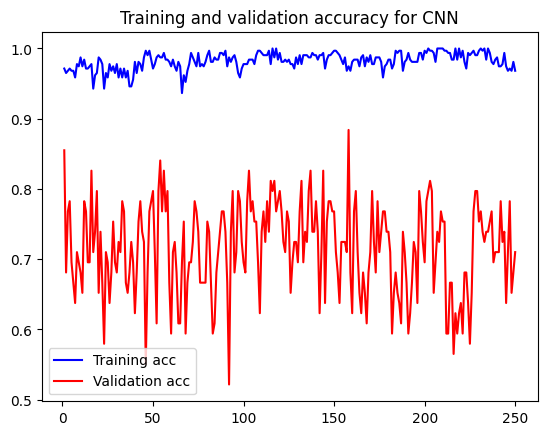

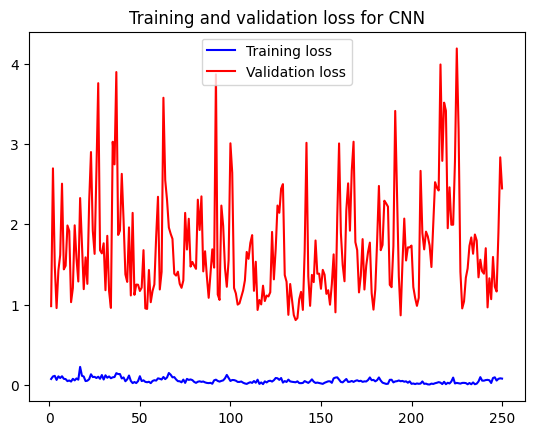

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

WIth 100 epochs:

accuracy: 0.9388 - loss: 0.1425 - val_accuracy: 0.5217 - val_loss: 3.4056

With 200 epochs:
accuracy: 0.9892 - loss: 0.0287 - val_accuracy: 0.8116 - val_loss: 1.0392

With 250 epochs:

accuracy: 0.9733 - loss: 0.0686 - val_accuracy: 0.7101 - val_loss: 2.4479

*With data augmentation and dropout, the gap between training and validation loss is reduced  and **validation accurracy reaches to 81% which is significantly better than the baseline model(33%)** at 200 epoched training.* This shows **overfitting**.

Further generalization can be improved by adding residual connections and replacing standard convolutions with depthwise-separable convolution

## 3.2 Residual Connections  and Depth-wise Separable Convolutions



###3.2.1 Residual Connections
A residual connectiond adds the input of a layer or block of layers back to its output (see figure below) allowing the model to skip the block if that block results in increased training error.

![residual connection](https://drive.google.com/uc?export=view&id=16_PbCxFhYdY809G90g5RMul2kB4QmbH5)

The residual connection acts as an information shortcut around a potentially destructive or noisy blocks, enabling error gradient information from early layers to propagate noiselessly
through a deep network. This technique was introduced in 2015 with the ResNet family of models

Here is a general pseudocode for adding a residual connection around a block:

```python
x=...
residual=x
x= block(x)
x=add(x,residual)
```
Where x is some input tensor. We set <code>residual=x</code> to save a pointer to original input. Then x goes through block(x) which could potentially be noisy or destructive. Finally, we add the original pointer we saved (i.e., residual) to x after going through block(x).

Note that adding the input back to the output of a block implies that the output should have the same shape as the input. To note, this is not the case if your block includes convolutional layers with an increased number of filters, or a max pooling layer. In such cases, use a 1x1 Conv2D layer with no activation to linearly project the residual to the desired output shape. If max pooling layer is used in the block to downsample, you can use strides in your 1x1 Conv2D layer to match any downsampling caused by max pooling.

Here is an example of a residual connection around a block consisting of a conv2d+batchnorm+relu+maxpooling layers:

```python
inputs = keras.Input(shape=(32, 32, 3)
#save a pointer to x
residual = x

#x goes through a block consisting of conv2d+batchnorm+reul+max pooling
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", use_bias=False)(x)
x= layers.BatchNormalization()(x)
x= layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

#After going through the above block x now has 64 channels and its feature map is downsampled to half (16,16) by max pooling
#while residual has 32 channels with a (32,32) feature map. before adding residual to x, we need to make them the same shape.
#We can use a one, by one convlution with stride 2 to downsample residual to (16,16) and increase it channels/filters to 64
residual = layers.Conv2D(filters=64, kernel_size=1, strides=2,use_bias=False)(residual)

#As usual we have a batchnormalization layer after convolution as usual
residual=layers.BatchNormalization()(residual)
x = layers.add([x, residual])
```




In [ ]:
#Residual

### 3.2.2 Depth-wise Separable Convolution
A depth-wise separable convolution decomposes a standard convolution to depthwise and pointwise convolutions and has significantly fewer parameters and involves fewer
computations compared to regular convolution, while having comparable representational power.

In keras, we can use <code>layers.SeparableConv2D</code> to create a depth-wise separable convolution.

### 3.2.3 Putting it together
Replaced <code>conv2D</code> layers with more parameter-efficient <code>SeparableConv2D</code> layers and added residual connections.  
It is also a common pratice to have CNNs that are repeated blocks of multiple convolution layers ( not just one) as we have seen in most modern CNN architectures like resnet, vggnet, etc.

In what follows we modify our baseline CNN model to a stack of residual blocks where each block consists of two depthwise convolution+batchnorm+relu as well as a max pooling layer. There is a residual connection around each block.
Note that the assumption that underlies separable convolution, “feature channels are largely independent,” does not hold for RGB images! Red, green, and blue color channels are actually highly correlated in natural images. As such, the first layer in our model is a regular Conv2D layer. We’ll start using SeparableConv2D afterwards.




In [ ]:
def build_baseline(input_shape, filters):
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)

  x = layers.Rescaling(1./255)(x)

  #In the first layer, the RGB channels are correlated
  x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

  for size in filters:
      #save x for residual connection
      residual = x

      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # The shape of "x" and "residual" do not match after downsampling with max pooling.
      # To match the shape of "residual" to "x", we apply a 1x1 convolution with a stride of 2.
      residual = layers.Conv2D(
          size, 1, strides=2, padding="same", use_bias=False)(residual)

      # add x to residual
      x = layers.add([x, residual])

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(3, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

baseline_improved=build_baseline(input_shape=(180,180,3), filters=[32,64,128,256, 512])
print(baseline_improved.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_20            │ (None, 180, 180, 3)    │              0 │ input_layer_4[0][0]    │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_20        │ (None, 180, 180, 3)    │              0 │ random_flip_20[0][0]   │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_20            │ (None, 180, 180, 3)    │              0 │ random_rotation_20[0]… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ random_zoom_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 176, 176, 32)   │          2,400 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 176, 176, 32)   │            128 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_50 (ReLU)           │ (None, 176, 176, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 176, 176, 32)   │          1,312 │ re_lu_50[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 176, 176, 32)   │            128 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_51 (ReLU)           │ (None, 176, 176, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 176, 176, 32)   │          1,312 │ re_lu_51[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 88, 88, 32)     │              0 │ separable_conv2d_1[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 88, 88, 32)     │          1,024 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 88, 88, 32)     │              0 │ max_pooling2d_20[0][0… │
│                      

 Total params: 722,883 (2.76 MB)

 Trainable params: 719,875 (2.75 MB)

 Non-trainable params: 3,008 (11.75 KB)

None


In [ ]:


#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baseline_improved.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/cnn_lab/baseline_improved_checkpoint.keras",save_best_only=True, monitor="val_loss")

history = baseline_improved.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 200,
            verbose = 1,
            callbacks=[checkpoint])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9526 - loss: 0.1189 - val_accuracy: 0.6812 - val_loss: 2.2927
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9501 - loss: 0.1713 - val_accuracy: 0.6667 - val_loss: 2.0565
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.9503 - loss: 0.1249 - val_accuracy: 0.6812 - val_loss: 1.7062
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9574 - loss: 0.1144 - val_accuracy: 0.7681 - val_loss: 1.0102
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.9663 - loss: 0.0960 - val_accuracy: 0.7101 - val_loss: 1.6461
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9798 - loss: 0.0737 - val_accuracy: 0.6377 - val_loss: 2.9138
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.9727 - loss: 0.0821 - val_accuracy: 0.7391 - val_loss: 1.0672
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.9684 - loss: 0.0977 - val_acc

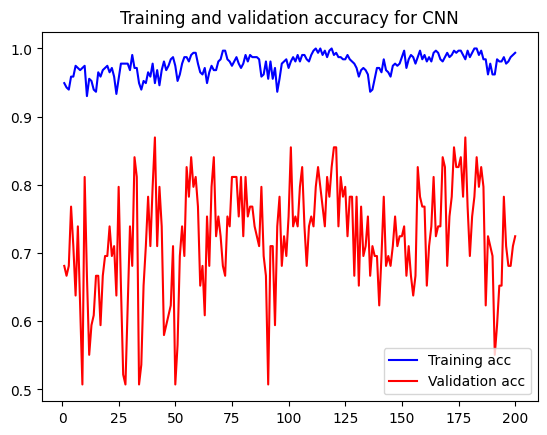

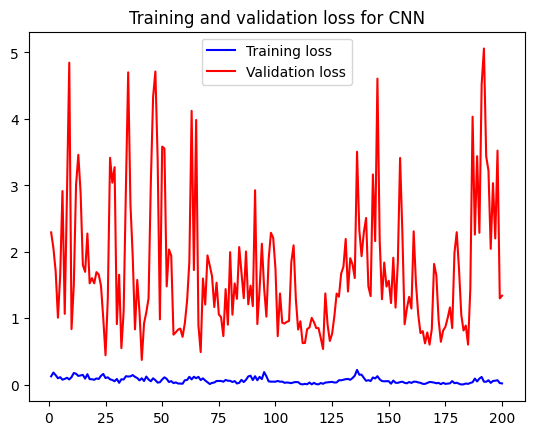

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

With 100 epochs:

accuracy: 0.9416 - loss: 0.1689 - val_accuracy: 0.6667 - val_loss: 1.3787

With 200 epochs:

accuracy: 0.9970 - loss: 0.0159 - val_accuracy: 0.7246 - val_loss: 1.3403

Shows sign of **overfitting**

(iii) *Using residual connections and depth-wise separable convolution did not show  improvement from our previous model.*



Tried replacing back the depthwise CNN layers with regular CNN but keep the residual connection to see how the. model perform as executed below.



In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_baseline(input_shape, filters):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)  # Normalize pixel values to [0,1] range

    # First layer: initialize with a regular Conv2D layer
    x = layers.Conv2D(filters=32, kernel_size=5, padding="same", use_bias=False)(x)

    for size in filters:
        # Save the current output as a residual connection
        residual = x

        # First Conv2D + BatchNorm + ReLU block
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(size, kernel_size=3, padding="same", use_bias=False)(x)

        # Second Conv2D + BatchNorm + ReLU block
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(size, kernel_size=3, padding="same", use_bias=False)(x)

        # Downsampling with MaxPooling2D
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Adjust the residual connection with Conv2D to match dimensions
        residual = layers.Conv2D(size, kernel_size=1, strides=2, padding="same", use_bias=False)(residual)
        residual = layers.BatchNormalization()(residual)

        # Add the residual connection to the output of the block
        x = layers.add([x, residual])

    # Global Average Pooling + Dropout + Dense output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation="softmax")(x)  # Adjust number of classes as needed

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model with updated Conv2D layers and residual connections
baseline_with_conv = build_baseline(input_shape=(180, 180, 3), filters=[32, 64, 128, 256, 512])
baseline_with_conv.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 180, 180, 32)   │          2,400 │ rescaling_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 180, 180, 32)   │            128 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_60 (ReLU)           │ (None, 180, 180, 32)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 180, 180, 32)   │          9,216 │ re_lu_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 180, 180, 32)   │            128 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_61 (ReLU)           │ (None, 180, 180, 32)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 180, 180, 32)   │          9,216 │ re_lu_61[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 90, 90, 32)     │          1,024 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 90, 90, 32)     │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 90, 90, 32)     │            128 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 90, 90, 32)     │              0 │ max_pooling2d_25[0][0… │
│                           │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 90, 90, 32)     │            128 │ add_5[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_62 (ReLU)           │ (None, 90, 90, 32)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 90, 90, 64)     │         18,432 │ re_lu_62[0][0]         │
├──────────────────────

 Total params: 4,907,619 (18.72 MB)

 Trainable params: 4,902,627 (18.70 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:


#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baseline_improved.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/cnn_lab/baseline_improved_checkpoint.keras",save_best_only=True, monitor="val_loss")

history = baseline_improved.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 200,
            verbose = 1,
            callbacks=[checkpoint])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9726 - loss: 0.0925 - val_accuracy: 0.7971 - val_loss: 0.6416
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9775 - loss: 0.0724 - val_accuracy: 0.6377 - val_loss: 1.7860
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9738 - loss: 0.0445 - val_accuracy: 0.8551 - val_loss: 0.4745
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9800 - loss: 0.0724 - val_accuracy: 0.8116 - val_loss: 0.8534
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9787 - loss: 0.0597 - val_accuracy: 0.7391 - val_loss: 2.0473
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9733 - loss: 0.0643 - val_accuracy: 0.7246 - val_loss: 2.3926
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9818 - loss: 0.0563 - val_accuracy: 0.6957 - val_loss: 1.8553
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9445 - loss: 0.2309 - val_acc

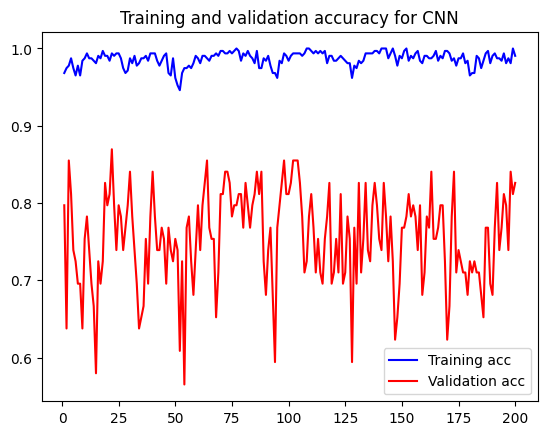

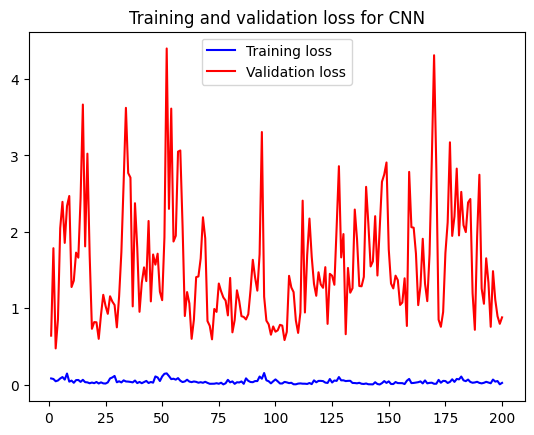

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

With 200 epochs:

accuracy: 0.9892 - loss: 0.0297 - val_accuracy: 0.8261 - val_loss: 0.8809

Validation accuracy is better here than the previous modelwhich has separable depth wise layers and residual blocks
(accuracy: 0.9970 - loss: 0.0159 - val_accuracy: 0.7246 - val_loss: 1.3403).

Yet the model is overfitting, further improvement is necessary for better model performance.

We can also tune the hyperparameter to try to increase validation accuracy even more but it would prove difficult to go any higher just by training   CNN from scratch, because you have so little data to work with. As a next step to improve  accuracy on this problem, we  have to use a pretrained model, which is the focus of the next two sections.

# 5. Transfer Learning: Using a Pre-trained model


A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

In this case, for example, consider a large convnet trained on the ImageNet dataset(1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.


## 5.1 Feature Extraction
We can take the convolutional base (convolutional layers + possibly batchnorm layers) of a well known architecture (such as VGG, ResNet, Inception, DenseNet etc.) pretrained on ImageNet, run the new dataset through it to extract features and train a new classifier with these features.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset
differs a lot from the dataset on which the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base. In this cases since the cat vs dog dataset is similar to the type of images in ImageNet, we will use the whole convolutional base.

Used **DenseNet121 architecture trained on ImageNet**. The DenseNet121 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Check [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications) for the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras applications.

You pass three arguments to the constructor:
- *weights*: specifies the weight checkpoint from which to initialize the model.
- *include_top*: refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog ), we don’t need to include it.
- *input_shape* is the shape of the image tensors that you’ll feed to the network.

Before you compile and train the model, it is very important to freeze the convolutional base. **Freezing a layer or set of layers means preventing their weights from being updated during training**. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. Weights are freezed by setting <code>conv-base.trainable=False</code>

In [ ]:


#instantiate a DenseNet121 model trained on ImageNet dataset
from tensorflow.keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
include_top=False,
input_shape=(180, 180, 3))

#freeze the weight of the convolutional base
conv_base.trainable=False

# get the summary of the model to view its architecture
conv_base.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 186, 186, 3)    │              0 │ input_layer_6[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 45, 45, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 45, 45, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 45, 45, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

We can see that the convolutional base of DenseNet121 has  millions of  parameters. Since the weights are frozen, none of these parameters are trainable.

We can create a model by stacking our own classifier (consisting of an average pooling layer (GAP) plus the output layer) on top of the convolutional base of DenseNet. We could optionally add one or more fully connected layer after the GAP layer but for this problem, since the cat vs cow vs dog dataset has similar type of images as imagenet, we get a good performance even without adding dense layers at the top.  



In [ ]:

def build_pretrained(input_shape):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #Add the data_augmentation layers here:
  x=data_augmentation(input)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.Rescaling(1./255)(x)

  #Using the pre-trained conv_base
  x = conv_base(x)

  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)

  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(3, activation="softmax")(x)

  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model

pretrained_model=build_pretrained(input_shape=(180,180,3))
print(pretrained_model.summary())



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_21 (RandomFlip)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_21 (RandomRotation)  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_21 (RandomZoom)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None


As seen above, the layers of the top classifier was added on top of the convolution based of densenet. The combined model has over  million parameters but only few of them are trainable. These are the parameters for the top classifier. The parameters of conv_base are frozen ( they don't get updated by training the model on cat-vs-dog dataset). More specifically, all  trainable parameters belong to the last dense layer (output layer). The GAP layer does not have any  parameter.

Now we compiled and fit the model as usual, then drew the learning curves

In [ ]:

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
pretrained_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)


history = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 200,
            verbose = 1,
            callbacks=[early_stopping])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.9005 - loss: 0.3176 - val_accuracy: 0.9710 - val_loss: 0.1609
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9421 - loss: 0.2329 - val_accuracy: 0.9710 - val_loss: 0.1311
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9309 - loss: 0.1876 - val_accuracy: 0.9710 - val_loss: 0.1155
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9528 - loss: 0.1738 - val_accuracy: 0.9710 - val_loss: 0.0952
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9326 - loss: 0.1707 - val_accuracy: 0.9710 - val_loss: 0.0960
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9634 - loss: 0.1348 - val_accuracy: 0.9855 - val_loss: 0.0791
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9779 - loss: 0.0961 - val_accuracy: 0.9710 - val_loss: 0.0787
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9363 - loss: 0.1610 - val_acc

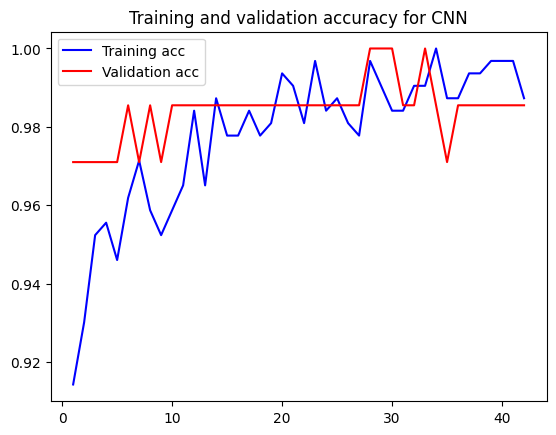

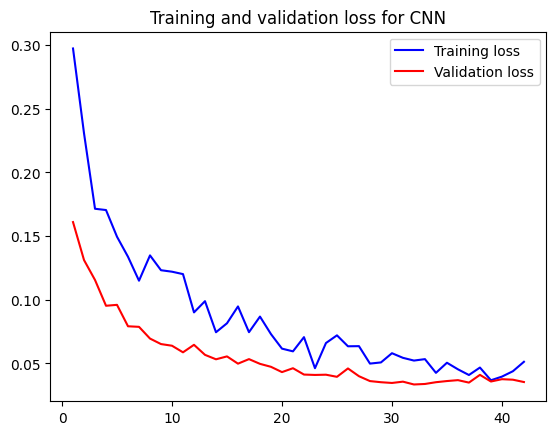

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

With 200 epochs of training:

accuracy: 0.9895 - loss: 0.0520 - val_accuracy: 0.9855 - val_loss: 0.0353

As seen above, **using transfer learning, we have reached a validation
accuracy of about 98%.** This is much better than what were able to achieved in the previous sections(77%-92%) with the convnet we trained from scratch(33%).

The learning curves are much more smooth and the model is **no longer overfitting** ( The validation accuracy is very close to the training accuracy, with only a small difference (98.95% vs. 98.55%)). Network showed  a higher training loss than the validation loss witha very smallgap between them.

This is because DesenNet uses drop out layers and it is common to see such pattern when we use dropout since drop out adds some noise during training ( randomly turns off some neurons) in order to increase model robustness and generalization. At the validation time though the drop out is not applied and hence if the network is not overfitting, the valdiation loss might end up being lower than the training loss as we see in the learning curves above.

## Fine Tuning

Once feature extraction is done and our newly added top classifier was trained on our target dataset (cat-vs-dog), we can unfreez some of the later convolutional layers in the pretrained network in order to make them more relevant for the problem at hand.

 The convolutional layers that come earlier in the pre-trained model extract local, highly generic feature maps (such as visual edges, colors, and textures) whereas layers that are higher up in the convolutional base extract more-abstract concepts (such as “cat ear” or “dog eye”) specific to the problem. therefore, it makes sense to unfreez some of the top convolution layers and train them some more on our target dataset.

Note that **fine tuning must be done after feature extraction is completed** Otherwise, if the top classifier is not already trained on the target data, the error signals propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.

So here are the steps for fine tuning:
* Do Feature Extraction as you did in the previous section to train the top classifier on the traget dataset
* Unfreez some of the top convolution layers in the pretrained network and train it on the target dataset.

Note that when we unfreez some layers in the pretrained network, we are NOT randomly initializing their weights/parameters but their weights are already learned on the pretrained dataset ( ImageNet for instance) and we are only adjusting them by training the network for a few iterations on the target dataset (cats-vs-dogs int this case)

Doing fine tuning in Keras is straightforward.We first make the conv_base model trainable by setting <code>conv_base.trainable</code> to true. Then we loop over each layer in conv_base and set <code>layer.trainable</code> to true if we want to tune that layer; otherwise we set it to false.

Looking at the architecture of DenseNEt121 in the previous section, let's tune the last convolutional block ( that is, the last 9 layers in the conv_base). We only want to fine-tune the convolutional layers. It is better to keep the batch normalization layers in the conv_base as frozen. Otherwise, they will keep updating their internal mean and variance,
which can interfere with the very small updates applied to the surrounding
Conv2D layers.



In [ ]:

#unfreez the convolution base
conv_base.trainable = True

#set trainable to False for all layers except the last 9 , that is freeze the weights for all layers except the last 9 layers
for layer in conv_base.layers[:-9]:
    layer.trainable=False

#set trainable to True for the convolutional layhers in the last 9 layers ( the last convolutional block in DENSENET121).
for layer in conv_base.layers[-9:]:
    # we only want to unfreez the convolutional layers (batch normalizataion layers remain frozen)
    if layer.name.endswith("conv"):
      layer.trainable=True

print(pretrained_model.summary())


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_21 (RandomFlip)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_21 (RandomRotation)  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_21 (RandomZoom)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,046,730 (26.88 MB)

 Trainable params: 171,203 (668.76 KB)

 Non-trainable params: 6,869,376 (26.20 MB)

 Optimizer params: 6,151 (24.03 KB)

None


**we also should use a very low learning rate when we do fine tuning because we want to limit the magnitude of the modifications we are  making to the representations of the conv layers we are fine-tuning**. Updates that are too large may harm these representations.


In [ ]:

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
pretrained_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)


history = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 200,
            verbose = 1,
            callbacks=[early_stopping])


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9708 - loss: 0.0977 - val_accuracy: 0.9855 - val_loss: 0.0341
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9675 - loss: 0.0908 - val_accuracy: 0.9855 - val_loss: 0.0346
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9768 - loss: 0.0871 - val_accuracy: 0.9855 - val_loss: 0.0353
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9834 - loss: 0.0800 - val_accuracy: 0.9855 - val_loss: 0.0356
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9869 - loss: 0.0617 - val_accuracy: 0.9855 - val_loss: 0.0361
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9857 - loss: 0.0799 - val_accuracy: 0.9855 - val_loss: 0.0364
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9551 - loss: 0.1169 - val_accuracy: 1.0000 - val_loss: 0.0366
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9378 - loss: 0.1178 - val_acc

At 10/200 epochs:

accuracy: 0.9886 - loss: 0.0696 - val_accuracy: 1.0000 - val_loss: 0.0372

Significant performance increase with fine-tuning is observed as validation accuracy reached 100% and higher than the training accuracy (98.86) in smaller number of epochs when compared with previous model without fine tuning and other non-pre-trained models trained. Validation loss is  lower than the training loss. Hence, fine-tuning is most helpful where the dataset we are training have different characteristics than the dataset the model is pretrained on.



Saved the trained model to disk because we will use it in CNN visualization lab **and to not loose once the session is terminated.**

**Since .h5 format is becoming legacy,  saved in the .keras format instead, which  helps with compatibility**

In [ ]:
#saving the model on disk
pretrained_model.save("drive/MyDrive/cnn_lab/cows-vs-cats-vs-dogs-finetuned.keras")

In [ ]:
import numpy as np

# Predict class probabilities for each test image
predicted_probabilities = pretrained_model.predict(test_dataset)


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [ ]:
# Get the index of the class with the highest probability
predicted_labels = np.argmax(predicted_probabilities, axis=1)


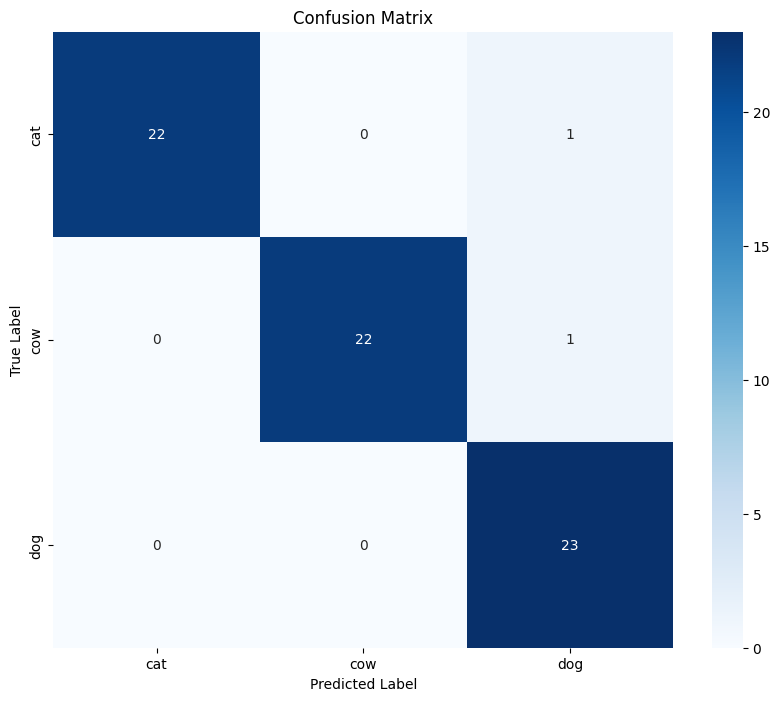

In [ ]:
#Referred google
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
true_labels=[]
for image_batch,label_batch in test_dataset:
    true_labels.extend(label_batch.numpy())
class_names=['cat','cow','dog']
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**cow, cat images are misclassified as dog.**

## Showing missclassified images in the validaiton data





The following code segment iterates through batches of images in the validation_dataset, get model predictions, find the images that were missclassified in the batch and displays them together with their predicted probabilities.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
True label is: cat, CNN predicted dog with confidence 0.78


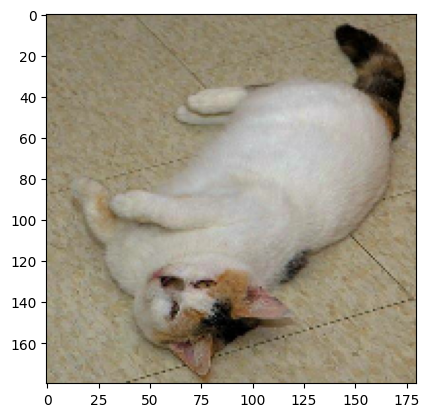

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True label is: cow, CNN predicted dog with confidence 0.49


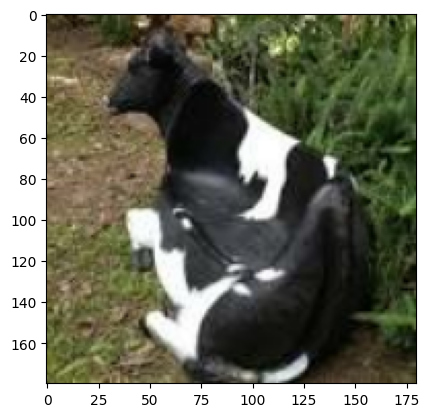

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:

#create a dictionary for label names. "dog" images are labled as 2, cat images are labeled as zer0 & cow as 1.
names={0:"cat", 1:"cow",2:"dog"}
batch_size=32
test_size=1000
batch_index=0
#Get each batch of images and labels in validation dataset
for image_batch,label_batch in test_dataset:
    if batch_index>math.ceil(test_size/batch_size):
        break;
    # Get the predicted probabilities for the images in the batch. It will return a numpy array of shape (1, batch_size), so flatten it to a vector
    #y_pred = pretrained_model.predict(image_batch).flatten()
    y_pred = pretrained_model.predict(image_batch)

    # If a predicted probability for an image is >0.5, set the predicted label to 1 otherwise to zero
    #y_pred_label=np.where(y_pred>0.5,1.,0.)
    y_pred_label = np.argmax(y_pred, axis=1)

    #get the indices of the missclassified images in the batch
    #errors = np.where(y_pred_label != label_batch)[0]
    errors = np.where(y_pred_label != label_batch.numpy())[0]

    #display the missclassified images together with their predicted probabilities
    for i in errors:
        true_label = label_batch[i].numpy()
        predicted_label = y_pred_label[i]

        #print(f"True label is: {names[label_batch[i].numpy()]}, CNN predicted {names[y_pred_label[i]]} with confidence {y_pred[i] if y_pred_label[i]==1.0 else 1-y_pred[i]}")
        print(
            f"True label is: {names[true_label]}, CNN predicted {names[predicted_label]} "
            f"with confidence {y_pred[i][predicted_label]:.2f}"
        )
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        plt.show()

    #get the next batch
    batch_index=batch_index+1


**Cow, cat images are mis-classified as dog.**

# 6. Computing the accuracy on the test data

Now that we are happy with the validaiton performance of the model, let's go ahead and compute its accurracy on the test data

In [ ]:
test_dir = os.path.join(base_dir, 'test')



#compute the loss and accurracy on the test set using model.evaluate method
test_loss, test_acc = pretrained_model.evaluate(test_dataset)
print('test acc:', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9699 - loss: 0.0760 
test acc: 0.9710144996643066


Test set accuracy obtained is 97.10%

====================THE END=====================
